In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
import argparse
import breizhcrops
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


# Define Transformer

In [5]:
import torch
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, Sequential, ReLU, GELU

import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange, repeat

__all__ = ['ViTransformer']

class ViTransformer(nn.Module):
    def __init__(self, input_dim=13, num_classes=9, time_dim = 45, d_model=64, n_head=2, n_layers=3,
                 d_inner=128, activation="relu", dropout=0.1):

        super(ViTransformer, self).__init__()
        self.modelname = f"TransformerEncoder_input-dim={input_dim}_num-classes={num_classes}_" \
                         f"d-model={d_model}_d-inner={d_inner}_n-layers={n_layers}_n-head={n_head}_" \
                         f"dropout={dropout}"

        encoder_layer = TransformerEncoderLayer(d_model, n_head, d_inner, dropout, activation)
        encoder_norm = LayerNorm(d_model)

        self.inlinear = Linear(input_dim, d_model)
        self.relu = ReLU()
        self.gelu = GELU()
        self.transformerencoder = TransformerEncoder(encoder_layer, n_layers, encoder_norm)

        self.pos_embedding = nn.Parameter(torch.randn(1, time_dim, d_model)) # T + class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model)) # class token

        self.dropout = nn.Dropout(dropout)

        self.n_units  = 128
        self.fc1 = Linear(d_model, self.n_units)
        
        self.dropout_p = 0.2
        self.dropout2 = nn.Dropout(p = self.dropout_p)
        
        self.mlp_head = nn.Sequential(
            LayerNorm(d_model),
            Linear(d_model, self.n_units),
            ReLU(),
            Linear(self.n_units, num_classes)
        )


    def forward(self,x):

        x = self.inlinear(x) # B x T x D

        b, n, _ = x.shape # B x T x D

        #cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)  # repeat for all batch
        #x = torch.cat((cls_tokens, x), dim=1) # concatenate on sequence [T + class token]
        x += self.pos_embedding[:, :(n)]
        
        x = x.transpose(0, 1) # N x T x D -> T x N x D
        x = self.transformerencoder(x)
        x = x.transpose(0, 1) # T x N x D -> N x T x D
        
        embeddings = x.max(1)[0]
        #x = x[:,0]  # take first dimension B x T x D

        logits = self.mlp_head(embeddings)
        
        logprobs = F.log_softmax(logits, dim=-1)
        
        return embeddings, logits, logprobs 

In [7]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import Adam
import torch
import pandas as pd
import os
import sklearn.metrics


def get_datasets(datapath, mode, batchsize, preload_ram=False, level="L2A"):
    print(f"Setting up datasets in {os.path.abspath(datapath)}, level {level}")
    datapath = os.path.abspath(datapath)

    frh01 = breizhcrops.BreizhCrops(region="frh01", root=datapath,
                                    preload_ram=preload_ram, level=level)
    frh02 = breizhcrops.BreizhCrops(region="frh02", root=datapath,
                                    preload_ram=preload_ram, level=level)
    frh03 = breizhcrops.BreizhCrops(region="frh03", root=datapath,
                                    preload_ram=preload_ram, level=level)
    if not "validation_only" in mode:
            frh04 = breizhcrops.BreizhCrops(region="frh04", root=datapath,
                                            preload_ram=preload_ram, level=level)

    if mode == "evaluation" or mode == "evaluation1":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02, frh03])
        testdataset = frh04
    elif mode == "evaluation2":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02, frh04])
        testdataset = frh03
    elif mode == "evaluation3":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh03, frh04])
        testdataset = frh02
    elif mode == "evaluation4":
        traindatasets = torch.utils.data.ConcatDataset([frh02, frh03, frh04])
        testdataset = frh01
    elif mode == "validation_only":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02])
        validationdataset = frh03
    elif mode == "validation_test":
        traindatasets = torch.utils.data.ConcatDataset([frh01, frh02])

        validationdataset = frh03
        testdataset = frh04
        
    elif mode == 'train1':
        traindatasets = frh01
        testdataset1 = frh02
        testdataset2 = frh03        
        testdataset3 = frh04
    elif mode == 'train2':
        traindatasets = frh02
        testdataset1 = frh01
        testdataset2 = frh03        
        testdataset3 = frh04
    elif mode == 'train3':
        traindatasets = frh03
        testdataset1 = frh01
        testdataset2 = frh02        
        testdataset3 = frh04  
    elif mode == 'train4':
        traindatasets = frh04
        testdataset1 = frh01
        testdataset2 = frh02        
        testdataset3 = frh03
        
    else:
        raise ValueError("only --mode 'validation' or 'evaluation' allowed")
    meta = dict(
        ndims=13 if level=="L1C" else 10,
        num_classes=len(frh01.classes),
        sequencelength=45
    )

    return traindatasets, testdataset1, testdataset2, testdataset3, meta   

def get_generic_dataloader(traindataset, batchsize=256, workers=4):
    dataloader = DataLoader(traindataset, batch_size=batchsize, shuffle=True, num_workers=workers)

    return dataloader

def get_dataloader(traindatasets,testdataset, validationdataset=None, batchsize=32, workers=4):
    traindataloader = DataLoader(traindatasets, batch_size=batchsize, shuffle=True, num_workers=workers)
    validationdataloader = DataLoader(validationdataset, batch_size=batchsize, shuffle=True, num_workers=workers)
    testdataloader = DataLoader(testdataset, batch_size=batchsize, shuffle=False, num_workers=workers)

    return traindataloader, validationdataloader, testdataloader

def get_dataloader2(traindatasets,testdataset1, testdataset2, testdataset3, batchsize=32, workers=4):
    traindataloader = DataLoader(traindatasets, batch_size=batchsize, shuffle=True, num_workers=workers)
    testdataloader1 = DataLoader(testdataset1, batch_size=batchsize, shuffle=False, num_workers=workers)
    testdataloader2 = DataLoader(testdataset2, batch_size=batchsize, shuffle=False, num_workers=workers)
    testdataloader3 = DataLoader(testdataset3, batch_size=batchsize, shuffle=False, num_workers=workers)

    return traindataloader, testdataloader1, testdataloader2, testdataloader3


def metrics(y_true, y_pred, training = False):
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    kappa = sklearn.metrics.cohen_kappa_score(y_true, y_pred)
    f1_micro = sklearn.metrics.f1_score(y_true, y_pred, average="micro")
    f1_macro = sklearn.metrics.f1_score(y_true, y_pred, average="macro")
    f1_weighted = sklearn.metrics.f1_score(y_true, y_pred, average="weighted")
    recall_micro = sklearn.metrics.recall_score(y_true, y_pred, average="micro")
    recall_macro = sklearn.metrics.recall_score(y_true, y_pred, average="macro")
    recall_weighted = sklearn.metrics.recall_score(y_true, y_pred, average="weighted")
    precision_micro = sklearn.metrics.precision_score(y_true, y_pred, average="micro")
    precision_macro = sklearn.metrics.precision_score(y_true, y_pred, average="macro")
    precision_weighted = sklearn.metrics.precision_score(y_true, y_pred, average="weighted")
    
    if training == True:
        return accuracy
    
    return dict(
        accuracy=accuracy,
        kappa=kappa,
        f1_micro=f1_micro,
        f1_macro=f1_macro,
        f1_weighted=f1_weighted,
        recall_micro=recall_micro,
        recall_macro=recall_macro,
        recall_weighted=recall_weighted,
        precision_micro=precision_micro,
        precision_macro=precision_macro,
        precision_weighted=precision_weighted,
    )


def train_epoch(model, optimizer, criterion, dataloader, device, running_loss):
    model.train()
    losses = list()
    y_true_list = list()
    y_pred_list = list()
    with tqdm(enumerate(dataloader), total=len(dataloader), leave=True) as iterator:
        for idx, batch in iterator:
            optimizer.zero_grad()
            x, y_true, _ = batch

            emb, logits, logprobabilities = model.forward(x.to(device))
            loss = criterion(logits, y_true.to(device))
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            y_true_list.append(y_true)
            y_pred_list.append(logits.argmax(-1))
            iterator.set_description(f"train loss={loss:.2f}")
            losses.append(loss)
            
            
    return running_loss, torch.stack(losses), torch.cat(y_true_list), torch.cat(y_pred_list)


def test_epoch(model, criterion, dataloader, device):
    model.eval()
    with torch.no_grad():
        losses = list()
        y_true_list = list()
        y_pred_list = list()
        y_score_list = list()
        field_ids_list = list()
        with tqdm(enumerate(dataloader), total=len(dataloader), leave=True) as iterator:
            for idx, batch in iterator:
                x, y_true, field_id = batch
                embs, logits, logprobabilities = model.forward(x.to(device))
                loss = criterion(logits, y_true.to(device))
                iterator.set_description(f"test loss={loss:.2f}")
                losses.append(loss)
                y_true_list.append(y_true)
                y_pred_list.append(logits.argmax(-1))
                y_score_list.append(logits.exp())
                field_ids_list.append(field_id)
        return torch.stack(losses), torch.cat(y_true_list), torch.cat(y_pred_list), torch.cat(y_score_list), torch.cat(field_ids_list)

# Define params

In [9]:
datapath = Path('breizhcrops_dataset')
model_dir = Path('models/torch_transformer/vio_trasformer_train2')
mode = 'train2'
batch_size = 256
learning_rate = 0.001

weight_decay = 5e-08
logdir = 'logs/torch_transformer'
workers = 4

# Define Dataloader

In [10]:
dataset1, dataset2, dataset3, dataset4, meta = get_datasets(datapath=datapath, mode=mode,
                                                        batchsize=batch_size, 
                                                        preload_ram=True, level="L2A")
num_classes = meta["num_classes"]
ndims = meta["ndims"]
sequencelength = meta["sequencelength"]

loading data into RAM:   0%|          | 0/178632 [00:00<?, ?it/s]

Setting up datasets in /home/mauromartini/mauro_ws/Remote_sensing_DANN/breizhcrops_dataset, level L2A


loading data into RAM: 100%|██████████| 122708/122708 [00:40<00:00, 3010.12it/s]


AttributeError: 'BreizhCrops' object has no attribute 'targets'

In [11]:
zone1dataloader, zone2dataloader, zone3dataloader, zone4dataloader = get_dataloader2(dataset1,
                                dataset2, dataset3, dataset4, batchsize=batch_size, workers=workers)

In [12]:
traindataloader = get_generic_dataloader(dataset1, batchsize=batch_size, workers=workers)

# Define Transformer model

In [13]:
num_classes=9
d_model=64
n_head=2
n_layers=3
d_inner=128

In [14]:
model = ViTransformer(input_dim=ndims, num_classes=num_classes, time_dim=sequencelength,
                      n_head=n_head, n_layers = n_layers,
                activation="relu",).to(device)

model.modelname += f"_learning-rate={learning_rate}_weight-decay={weight_decay}"
print(f"Initialized {model.modelname}")

Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08


In [15]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [16]:
params

122121

In [15]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter(logdir)

#  Train Transformer

In [16]:
zones = 4
dataloaders = [(zone1dataloader,'zone1'), (zone2dataloader,'zone2'), (zone3dataloader,'zone3'), (zone4dataloader,'zone4')]
epochs = 250
save_freq = 10

for i in range(zones):
    
    traindataloader = dataloaders[i][0]
    train_zone = dataloaders[i][1]
    print('Training zone:', train_zone)
    
    path = 'models/torch_transformer/vio_trasformer_train'+str(i+1)
    model_dir = Path(path)
    
    model = ViTransformer(input_dim=ndims, num_classes=num_classes, time_dim=sequencelength, 
                          n_head=n_head, 
                          n_layers = n_layers, 
                          activation="relu",).to(device)

    model.modelname += f"_learning-rate={learning_rate}_weight-decay={weight_decay}"
    print(f"Initialized {model.modelname}")

    losses = np.empty(epochs)
    criterion = torch.nn.CrossEntropyLoss(reduction="mean")

    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    lambda2 = lambda epoch: 0.99 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda2)
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_loss, train_loss, y_true, y_pred  = train_epoch(model, optimizer, criterion, traindataloader, device, running_loss)
        losses[epoch] = running_loss / len(traindataloader)
        train_scores = metrics(y_true.cpu(), y_pred.cpu())
        # Record loss and accuracy into the writer for training
        #writer.add_scalar('Train/Loss', losses[epoch], epoch)
        #train_accuracy = train_scores["accuracy"]
        #writer.add_scalar('Train/Accuracy', train_accuracy, epoch)
        #writer.flush()

    #    test_loss, y_true, y_pred, *_ = test_epoch(model, criterion, validationdataloader, device)
    #    testloss = torch.sum(test_loss)/len(validationdataloader)

        scheduler.step()

    #    scores = metrics(y_true.cpu(), y_pred.cpu())
    #    test_accuracy = scores["accuracy"]

        # Record loss and accuracy into the writer for valdation
    #    writer.add_scalar('Validation/Loss', testloss, epoch)
    #    writer.add_scalar('Validation/Accuracy', test_accuracy, epoch)
    #    writer.flush()

    #    scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])
    #    test_loss = test_loss.cpu().detach().numpy()[0]
        train_loss = train_loss.cpu().detach().numpy()[0]
    #    print(f"epoch {epoch}: trainloss {train_loss:.2f}, testloss {test_loss:.2f} " + scores_msg)
        print(f"epoch {epoch}: trainloss {train_loss:.2f}")

    #    scores["epoch"] = epoch
    #    scores["trainloss"] = train_loss
    #    scores["testloss"] = test_loss
        if epoch % save_freq == 0:
            torch.save(model.state_dict(), model_dir)
    torch.save(model.state_dict(), model_dir)

Training zone: zone1
Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08


train loss=0.77: 100%|██████████| 698/698 [00:20<00:00, 33.93it/s]


epoch 0: trainloss 2.31


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.72: 100%|██████████| 698/698 [00:20<00:00, 34.53it/s]


epoch 1: trainloss 0.68


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.64: 100%|██████████| 698/698 [00:21<00:00, 33.24it/s]


epoch 2: trainloss 0.60


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.47: 100%|██████████| 698/698 [00:20<00:00, 34.17it/s]


epoch 3: trainloss 0.59


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.51: 100%|██████████| 698/698 [00:20<00:00, 33.73it/s]


epoch 4: trainloss 0.57


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.57: 100%|██████████| 698/698 [00:20<00:00, 33.92it/s]


epoch 5: trainloss 0.48


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.56: 100%|██████████| 698/698 [00:20<00:00, 34.37it/s]


epoch 6: trainloss 0.44


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:20<00:00, 33.64it/s]


epoch 7: trainloss 0.47


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.49: 100%|██████████| 698/698 [00:20<00:00, 34.43it/s]


epoch 8: trainloss 0.49


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.49: 100%|██████████| 698/698 [00:20<00:00, 33.33it/s]


epoch 9: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.45: 100%|██████████| 698/698 [00:20<00:00, 34.01it/s]


epoch 10: trainloss 0.47


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.44: 100%|██████████| 698/698 [00:20<00:00, 33.69it/s]


epoch 11: trainloss 0.51


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.47: 100%|██████████| 698/698 [00:20<00:00, 34.34it/s]


epoch 12: trainloss 0.45


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 698/698 [00:20<00:00, 34.41it/s]


epoch 13: trainloss 0.51


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 698/698 [00:20<00:00, 33.53it/s]


epoch 14: trainloss 0.49


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.55: 100%|██████████| 698/698 [00:20<00:00, 34.40it/s]


epoch 15: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 33.40it/s]


epoch 16: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 698/698 [00:20<00:00, 34.35it/s]


epoch 17: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.44: 100%|██████████| 698/698 [00:20<00:00, 34.03it/s]


epoch 18: trainloss 0.43


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 698/698 [00:20<00:00, 34.32it/s]


epoch 19: trainloss 0.46


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 698/698 [00:20<00:00, 33.78it/s]


epoch 20: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.46: 100%|██████████| 698/698 [00:20<00:00, 34.38it/s]


epoch 21: trainloss 0.43


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.45: 100%|██████████| 698/698 [00:20<00:00, 34.24it/s]


epoch 22: trainloss 0.48


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 698/698 [00:20<00:00, 33.53it/s]


epoch 23: trainloss 0.47


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 698/698 [00:20<00:00, 34.03it/s]


epoch 24: trainloss 0.43


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 33.64it/s]


epoch 25: trainloss 0.52


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 34.14it/s]


epoch 26: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.44: 100%|██████████| 698/698 [00:20<00:00, 33.68it/s]


epoch 27: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:20<00:00, 33.91it/s]


epoch 28: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.76it/s]


epoch 29: trainloss 0.43


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:20<00:00, 34.12it/s]


epoch 30: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 698/698 [00:20<00:00, 34.78it/s]


epoch 31: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 698/698 [00:20<00:00, 33.76it/s]


epoch 32: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 698/698 [00:20<00:00, 34.48it/s]


epoch 33: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 698/698 [00:20<00:00, 33.29it/s]


epoch 34: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:20<00:00, 34.18it/s]


epoch 35: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 698/698 [00:20<00:00, 33.81it/s]


epoch 36: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 34.21it/s]


epoch 37: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.46: 100%|██████████| 698/698 [00:20<00:00, 34.28it/s]


epoch 38: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 698/698 [00:20<00:00, 33.44it/s]


epoch 39: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 698/698 [00:20<00:00, 34.23it/s]


epoch 40: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 33.27it/s]


epoch 41: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 34.42it/s]


epoch 42: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.51: 100%|██████████| 698/698 [00:20<00:00, 33.25it/s]


epoch 43: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.44: 100%|██████████| 698/698 [00:20<00:00, 33.72it/s]


epoch 44: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 698/698 [00:20<00:00, 33.32it/s]


epoch 45: trainloss 0.29


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 698/698 [00:20<00:00, 34.04it/s]


epoch 46: trainloss 0.44


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 33.61it/s]


epoch 47: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.35it/s]


epoch 48: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 33.87it/s]


epoch 49: trainloss 0.32


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 33.59it/s]


epoch 50: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 33.66it/s]


epoch 51: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 33.35it/s]


epoch 52: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 698/698 [00:20<00:00, 33.73it/s]


epoch 53: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 34.22it/s]


epoch 54: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:20<00:00, 33.35it/s]


epoch 55: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 33.91it/s]


epoch 56: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 33.46it/s]


epoch 57: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 698/698 [00:20<00:00, 33.47it/s]


epoch 58: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 698/698 [00:21<00:00, 33.11it/s]


epoch 59: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 698/698 [00:20<00:00, 33.53it/s]


epoch 60: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 33.89it/s]


epoch 61: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:21<00:00, 33.12it/s]


epoch 62: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 33.90it/s]


epoch 63: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 698/698 [00:21<00:00, 32.98it/s]


epoch 64: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 698/698 [00:20<00:00, 34.03it/s]


epoch 65: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 33.52it/s]


epoch 66: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:20<00:00, 33.73it/s]


epoch 67: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 698/698 [00:20<00:00, 33.87it/s]


epoch 68: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 698/698 [00:21<00:00, 33.21it/s]


epoch 69: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:20<00:00, 34.11it/s]


epoch 70: trainloss 0.30


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.24: 100%|██████████| 698/698 [00:20<00:00, 33.27it/s]


epoch 71: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 33.90it/s]


epoch 72: trainloss 0.32


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 698/698 [00:21<00:00, 33.22it/s]


epoch 73: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 33.86it/s]


epoch 74: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 34.18it/s]


epoch 75: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:21<00:00, 33.15it/s]


epoch 76: trainloss 0.30


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 33.48it/s]


epoch 77: trainloss 0.33


train loss=0.40: 100%|██████████| 698/698 [00:20<00:00, 33.37it/s]


epoch 78: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:20<00:00, 33.50it/s]


epoch 79: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.30: 100%|██████████| 698/698 [00:21<00:00, 32.96it/s]


epoch 80: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 33.70it/s]


epoch 81: trainloss 0.32


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 34.29it/s]


epoch 82: trainloss 0.47


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 33.38it/s]


epoch 83: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 34.31it/s]


epoch 84: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 698/698 [00:21<00:00, 33.08it/s]


epoch 85: trainloss 0.45


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 33.78it/s]


epoch 86: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 33.68it/s]


epoch 87: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 33.96it/s]


epoch 88: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.65it/s]


epoch 89: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 33.43it/s]


epoch 90: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 34.33it/s]


epoch 91: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 33.36it/s]


epoch 92: trainloss 0.32


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.25: 100%|██████████| 698/698 [00:20<00:00, 33.77it/s]


epoch 93: trainloss 0.31


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 698/698 [00:20<00:00, 33.39it/s]


epoch 94: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 33.76it/s]


epoch 95: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 698/698 [00:21<00:00, 33.11it/s]


epoch 96: trainloss 0.27


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 33.73it/s]


epoch 97: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 34.11it/s]


epoch 98: trainloss 0.31


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 33.34it/s]


epoch 99: trainloss 0.31


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 33.84it/s]


epoch 100: trainloss 0.29


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 33.38it/s]


epoch 101: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 698/698 [00:20<00:00, 33.63it/s]


epoch 102: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:21<00:00, 33.03it/s]


epoch 103: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 33.68it/s]


epoch 104: trainloss 0.48


train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 33.48it/s]


epoch 105: trainloss 0.31


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 698/698 [00:21<00:00, 32.99it/s]


epoch 106: trainloss 0.43


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 34.19it/s]


epoch 107: trainloss 0.28


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.26: 100%|██████████| 698/698 [00:20<00:00, 33.38it/s]


epoch 108: trainloss 0.38


train loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.89it/s]


epoch 109: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 698/698 [00:20<00:00, 33.24it/s]


epoch 110: trainloss 0.31


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 698/698 [00:20<00:00, 33.89it/s]


epoch 111: trainloss 0.39


train loss=0.45: 100%|██████████| 698/698 [00:20<00:00, 33.86it/s]


epoch 112: trainloss 0.34


train loss=0.40: 100%|██████████| 698/698 [00:21<00:00, 32.94it/s]


epoch 113: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.28: 100%|██████████| 698/698 [00:20<00:00, 34.09it/s]


epoch 114: trainloss 0.27


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.29: 100%|██████████| 698/698 [00:21<00:00, 33.05it/s]


epoch 115: trainloss 0.32


train loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.87it/s]


epoch 116: trainloss 0.33


train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 33.38it/s]


epoch 117: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 33.63it/s]


epoch 118: trainloss 0.27


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 698/698 [00:20<00:00, 33.45it/s]


epoch 119: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.80it/s]


epoch 120: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 34.05it/s]


epoch 121: trainloss 0.38


train loss=0.35: 100%|██████████| 698/698 [00:21<00:00, 33.02it/s]


epoch 122: trainloss 0.39


train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 34.37it/s]


epoch 123: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 33.26it/s]


epoch 124: trainloss 0.32


train loss=0.39: 100%|██████████| 698/698 [00:20<00:00, 33.66it/s]


epoch 125: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 698/698 [00:20<00:00, 33.59it/s]


epoch 126: trainloss 0.44


train loss=0.23: 100%|██████████| 698/698 [00:20<00:00, 33.63it/s]


epoch 127: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 33.94it/s]


epoch 128: trainloss 0.28


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 33.29it/s]


epoch 129: trainloss 0.30


train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 34.27it/s]


epoch 130: trainloss 0.35


train loss=0.43: 100%|██████████| 698/698 [00:20<00:00, 33.39it/s]


epoch 131: trainloss 0.27


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 33.71it/s]


epoch 132: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.24: 100%|██████████| 698/698 [00:20<00:00, 33.63it/s]


epoch 133: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 34.21it/s]


epoch 134: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 34.19it/s]


epoch 135: trainloss 0.27


train loss=0.37: 100%|██████████| 698/698 [00:21<00:00, 33.22it/s]


epoch 136: trainloss 0.29


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 34.01it/s]


epoch 137: trainloss 0.30


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 33.39it/s]


epoch 138: trainloss 0.29


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:20<00:00, 33.89it/s]


epoch 139: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.28: 100%|██████████| 698/698 [00:20<00:00, 34.00it/s]


epoch 140: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.69it/s]


epoch 141: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 33.82it/s]


epoch 142: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 698/698 [00:21<00:00, 33.14it/s]


epoch 143: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 698/698 [00:20<00:00, 34.62it/s]


epoch 144: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 33.28it/s]


epoch 145: trainloss 0.33


train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 34.18it/s]


epoch 146: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 33.84it/s]


epoch 147: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 33.57it/s]


epoch 148: trainloss 0.33


train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 33.40it/s]


epoch 149: trainloss 0.41


train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 33.61it/s]


epoch 150: trainloss 0.27


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 33.78it/s]


epoch 151: trainloss 0.31


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.28: 100%|██████████| 698/698 [00:20<00:00, 33.47it/s]


epoch 152: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 698/698 [00:20<00:00, 34.48it/s]


epoch 153: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 33.41it/s]


epoch 154: trainloss 0.36


train loss=0.28: 100%|██████████| 698/698 [00:20<00:00, 33.92it/s]


epoch 155: trainloss 0.37


train loss=0.38: 100%|██████████| 698/698 [00:20<00:00, 33.45it/s]


epoch 156: trainloss 0.33


train loss=0.33: 100%|██████████| 698/698 [00:20<00:00, 33.75it/s]


epoch 157: trainloss 0.32


train loss=0.26: 100%|██████████| 698/698 [00:20<00:00, 34.40it/s]


epoch 158: trainloss 0.30


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 698/698 [00:21<00:00, 33.04it/s]


epoch 159: trainloss 0.31


train loss=0.40: 100%|██████████| 698/698 [00:20<00:00, 34.07it/s]


epoch 160: trainloss 0.31


train loss=0.36: 100%|██████████| 698/698 [00:21<00:00, 33.00it/s]


epoch 161: trainloss 0.32


train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 34.01it/s]


epoch 162: trainloss 0.32


train loss=0.40: 100%|██████████| 698/698 [00:21<00:00, 33.08it/s]


epoch 163: trainloss 0.36


train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 33.57it/s]


epoch 164: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 33.90it/s]


epoch 165: trainloss 0.28


train loss=0.43: 100%|██████████| 698/698 [00:21<00:00, 32.93it/s]


epoch 166: trainloss 0.29


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 698/698 [00:20<00:00, 33.99it/s]


epoch 167: trainloss 0.40


train loss=0.32: 100%|██████████| 698/698 [00:21<00:00, 33.21it/s]


epoch 168: trainloss 0.30


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 33.48it/s]


epoch 169: trainloss 0.28


train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 33.27it/s]


epoch 170: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.22: 100%|██████████| 698/698 [00:20<00:00, 33.39it/s]


epoch 171: trainloss 0.30


train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 33.41it/s]


epoch 172: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:21<00:00, 33.10it/s]


epoch 173: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 698/698 [00:20<00:00, 33.98it/s]


epoch 174: trainloss 0.34


train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 33.38it/s]


epoch 175: trainloss 0.28


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 33.83it/s]


epoch 176: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 698/698 [00:21<00:00, 33.11it/s]


epoch 177: trainloss 0.28


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 698/698 [00:20<00:00, 33.64it/s]


epoch 178: trainloss 0.35


train loss=0.40: 100%|██████████| 698/698 [00:20<00:00, 33.36it/s]


epoch 179: trainloss 0.32


train loss=0.49: 100%|██████████| 698/698 [00:20<00:00, 33.27it/s]


epoch 180: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 698/698 [00:20<00:00, 34.08it/s]


epoch 181: trainloss 0.30


train loss=0.31: 100%|██████████| 698/698 [00:21<00:00, 33.01it/s]


epoch 182: trainloss 0.31


train loss=0.41: 100%|██████████| 698/698 [00:20<00:00, 33.87it/s]


epoch 183: trainloss 0.32


train loss=0.31: 100%|██████████| 698/698 [00:21<00:00, 32.82it/s]


epoch 184: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 33.81it/s]


epoch 185: trainloss 0.27


train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 33.50it/s]


epoch 186: trainloss 0.28


train loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.95it/s]


epoch 187: trainloss 0.33


train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 34.14it/s]


epoch 188: trainloss 0.30


train loss=0.33: 100%|██████████| 698/698 [00:21<00:00, 33.17it/s]


epoch 189: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 34.23it/s]


epoch 190: trainloss 0.27


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:21<00:00, 33.01it/s]


epoch 191: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.23: 100%|██████████| 698/698 [00:20<00:00, 33.88it/s]


epoch 192: trainloss 0.36


train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 33.60it/s]


epoch 193: trainloss 0.40


train loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.88it/s]


epoch 194: trainloss 0.30


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 34.06it/s]


epoch 195: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 33.42it/s]


epoch 196: trainloss 0.32


train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 33.83it/s]


epoch 197: trainloss 0.35


train loss=0.30: 100%|██████████| 698/698 [00:21<00:00, 32.72it/s]


epoch 198: trainloss 0.27


train loss=0.39: 100%|██████████| 698/698 [00:20<00:00, 34.10it/s]


epoch 199: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:20<00:00, 33.34it/s]


epoch 200: trainloss 0.31


train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 33.90it/s]


epoch 201: trainloss 0.31


train loss=0.39: 100%|██████████| 698/698 [00:20<00:00, 33.79it/s]


epoch 202: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 698/698 [00:20<00:00, 33.29it/s]


epoch 203: trainloss 0.34


train loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.97it/s]


epoch 204: trainloss 0.31


train loss=0.29: 100%|██████████| 698/698 [00:21<00:00, 33.22it/s]


epoch 205: trainloss 0.31


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 698/698 [00:20<00:00, 33.98it/s]


epoch 206: trainloss 0.34


train loss=0.39: 100%|██████████| 698/698 [00:20<00:00, 33.69it/s]


epoch 207: trainloss 0.32


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 698/698 [00:20<00:00, 33.85it/s]


epoch 208: trainloss 0.31


train loss=0.28: 100%|██████████| 698/698 [00:20<00:00, 33.34it/s]


epoch 209: trainloss 0.34


train loss=0.28: 100%|██████████| 698/698 [00:20<00:00, 33.72it/s]


epoch 210: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 698/698 [00:20<00:00, 33.72it/s]


epoch 211: trainloss 0.31


train loss=0.39: 100%|██████████| 698/698 [00:21<00:00, 32.85it/s]


epoch 212: trainloss 0.26


train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 33.88it/s]


epoch 213: trainloss 0.29


train loss=0.43: 100%|██████████| 698/698 [00:20<00:00, 33.86it/s]


epoch 214: trainloss 0.32


train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 34.01it/s]


epoch 215: trainloss 0.30


train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 33.94it/s]


epoch 216: trainloss 0.33


train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 34.04it/s]


epoch 217: trainloss 0.28


train loss=0.38: 100%|██████████| 698/698 [00:20<00:00, 33.88it/s]


epoch 218: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 698/698 [00:21<00:00, 32.76it/s]


epoch 219: trainloss 0.29


train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 33.97it/s]


epoch 220: trainloss 0.33


train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 33.38it/s]


epoch 221: trainloss 0.40


train loss=0.33: 100%|██████████| 698/698 [00:20<00:00, 33.38it/s]


epoch 222: trainloss 0.40


train loss=0.30: 100%|██████████| 698/698 [00:21<00:00, 33.23it/s]


epoch 223: trainloss 0.29


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 33.55it/s]


epoch 224: trainloss 0.35


train loss=0.32: 100%|██████████| 698/698 [00:20<00:00, 33.68it/s]


epoch 225: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.29: 100%|██████████| 698/698 [00:21<00:00, 32.99it/s]


epoch 226: trainloss 0.31


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 698/698 [00:20<00:00, 34.13it/s]


epoch 227: trainloss 0.31


train loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.34it/s]


epoch 228: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 33.47it/s]


epoch 229: trainloss 0.34


train loss=0.35: 100%|██████████| 698/698 [00:20<00:00, 33.29it/s]


epoch 230: trainloss 0.35


train loss=0.39: 100%|██████████| 698/698 [00:20<00:00, 33.49it/s]


epoch 231: trainloss 0.32


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 33.61it/s]


epoch 232: trainloss 0.29


train loss=0.33: 100%|██████████| 698/698 [00:21<00:00, 33.20it/s]


epoch 233: trainloss 0.27


train loss=0.46: 100%|██████████| 698/698 [00:20<00:00, 33.58it/s]


epoch 234: trainloss 0.31


train loss=0.33: 100%|██████████| 698/698 [00:21<00:00, 33.22it/s]


epoch 235: trainloss 0.29


train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 33.88it/s]


epoch 236: trainloss 0.34


train loss=0.26: 100%|██████████| 698/698 [00:20<00:00, 33.72it/s]


epoch 237: trainloss 0.25


train loss=0.42: 100%|██████████| 698/698 [00:20<00:00, 34.04it/s]


epoch 238: trainloss 0.33


train loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.85it/s]


epoch 239: trainloss 0.34


train loss=0.40: 100%|██████████| 698/698 [00:20<00:00, 33.32it/s]


epoch 240: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 698/698 [00:20<00:00, 33.90it/s]


epoch 241: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.28: 100%|██████████| 698/698 [00:20<00:00, 33.57it/s]


epoch 242: trainloss 0.32


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.28: 100%|██████████| 698/698 [00:20<00:00, 33.88it/s]


epoch 243: trainloss 0.29


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 33.51it/s]


epoch 244: trainloss 0.29


train loss=0.37: 100%|██████████| 698/698 [00:20<00:00, 34.02it/s]


epoch 245: trainloss 0.29


train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 34.03it/s]


epoch 246: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.29: 100%|██████████| 698/698 [00:20<00:00, 33.32it/s]


epoch 247: trainloss 0.25


train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 33.82it/s]


epoch 248: trainloss 0.39


train loss=0.34: 100%|██████████| 698/698 [00:20<00:00, 33.43it/s]


epoch 249: trainloss 0.30
Training zone: zone2
Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08


train loss=0.74: 100%|██████████| 550/550 [00:15<00:00, 34.50it/s]


epoch 0: trainloss 2.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.67: 100%|██████████| 550/550 [00:16<00:00, 33.43it/s]


epoch 1: trainloss 0.84


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.61: 100%|██████████| 550/550 [00:15<00:00, 34.78it/s]


epoch 2: trainloss 0.75


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.58: 100%|██████████| 550/550 [00:16<00:00, 33.41it/s]


epoch 3: trainloss 0.67


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.56: 100%|██████████| 550/550 [00:16<00:00, 33.55it/s]


epoch 4: trainloss 0.62


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.54: 100%|██████████| 550/550 [00:16<00:00, 34.28it/s]


epoch 5: trainloss 0.60


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.51: 100%|██████████| 550/550 [00:16<00:00, 33.86it/s]


epoch 6: trainloss 0.59


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.51: 100%|██████████| 550/550 [00:16<00:00, 33.84it/s]


epoch 7: trainloss 0.56


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.51: 100%|██████████| 550/550 [00:16<00:00, 32.91it/s]


epoch 8: trainloss 0.54


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.51: 100%|██████████| 550/550 [00:15<00:00, 34.63it/s]


epoch 9: trainloss 0.55


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.47: 100%|██████████| 550/550 [00:16<00:00, 33.63it/s]


epoch 10: trainloss 0.53


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.47: 100%|██████████| 550/550 [00:15<00:00, 34.43it/s]


epoch 11: trainloss 0.53


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.47: 100%|██████████| 550/550 [00:16<00:00, 33.19it/s]


epoch 12: trainloss 0.55


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.48: 100%|██████████| 550/550 [00:16<00:00, 33.45it/s]


epoch 13: trainloss 0.51


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.46: 100%|██████████| 550/550 [00:16<00:00, 34.27it/s]


epoch 14: trainloss 0.49


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.46: 100%|██████████| 550/550 [00:16<00:00, 33.50it/s]


epoch 15: trainloss 0.52


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.46: 100%|██████████| 550/550 [00:16<00:00, 33.71it/s]


epoch 16: trainloss 0.50


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.45: 100%|██████████| 550/550 [00:16<00:00, 33.37it/s]


epoch 17: trainloss 0.48


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.48: 100%|██████████| 550/550 [00:15<00:00, 34.55it/s]


epoch 18: trainloss 0.48


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.46: 100%|██████████| 550/550 [00:16<00:00, 33.14it/s]


epoch 19: trainloss 0.50


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 550/550 [00:16<00:00, 34.17it/s]


epoch 20: trainloss 0.52


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.45: 100%|██████████| 550/550 [00:16<00:00, 33.12it/s]


epoch 21: trainloss 0.48


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.45: 100%|██████████| 550/550 [00:16<00:00, 33.72it/s]


epoch 22: trainloss 0.49


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 550/550 [00:16<00:00, 33.53it/s]


epoch 23: trainloss 0.46


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 550/550 [00:16<00:00, 33.69it/s]


epoch 24: trainloss 0.48


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.47: 100%|██████████| 550/550 [00:16<00:00, 33.98it/s]


epoch 25: trainloss 0.47


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 550/550 [00:16<00:00, 33.04it/s]


epoch 26: trainloss 0.47


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.45: 100%|██████████| 550/550 [00:16<00:00, 33.93it/s]


epoch 27: trainloss 0.45


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 550/550 [00:16<00:00, 33.18it/s]


epoch 28: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 550/550 [00:16<00:00, 34.28it/s]


epoch 29: trainloss 0.43


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.46: 100%|██████████| 550/550 [00:16<00:00, 33.41it/s]


epoch 30: trainloss 0.44


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 550/550 [00:15<00:00, 34.39it/s]


epoch 31: trainloss 0.43


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 550/550 [00:16<00:00, 33.34it/s]


epoch 32: trainloss 0.43


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 550/550 [00:16<00:00, 33.32it/s]


epoch 33: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 550/550 [00:16<00:00, 34.17it/s]


epoch 34: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 550/550 [00:16<00:00, 33.76it/s]


epoch 35: trainloss 0.43


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 550/550 [00:16<00:00, 33.56it/s]


epoch 36: trainloss 0.44


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 550/550 [00:16<00:00, 32.90it/s]


epoch 37: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 550/550 [00:16<00:00, 34.34it/s]


epoch 38: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 550/550 [00:16<00:00, 33.27it/s]


epoch 39: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 550/550 [00:16<00:00, 34.09it/s]


epoch 40: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 550/550 [00:16<00:00, 33.08it/s]


epoch 41: trainloss 0.43


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 550/550 [00:16<00:00, 33.31it/s]


epoch 42: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 550/550 [00:16<00:00, 33.71it/s]


epoch 43: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 550/550 [00:16<00:00, 32.92it/s]


epoch 44: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 550/550 [00:16<00:00, 34.00it/s]


epoch 45: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 550/550 [00:16<00:00, 32.97it/s]


epoch 46: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 34.00it/s]


epoch 47: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 550/550 [00:16<00:00, 33.24it/s]


epoch 48: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 550/550 [00:16<00:00, 33.67it/s]


epoch 49: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 550/550 [00:16<00:00, 33.28it/s]


epoch 50: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 550/550 [00:16<00:00, 33.52it/s]


epoch 51: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 550/550 [00:16<00:00, 33.12it/s]


epoch 52: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.59it/s]


epoch 53: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 550/550 [00:16<00:00, 33.37it/s]


epoch 54: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.52it/s]


epoch 55: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 550/550 [00:16<00:00, 34.07it/s]


epoch 56: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 550/550 [00:16<00:00, 33.41it/s]


epoch 57: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 550/550 [00:15<00:00, 34.43it/s]


epoch 58: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 32.75it/s]


epoch 59: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 34.33it/s]


epoch 60: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 550/550 [00:16<00:00, 33.17it/s]


epoch 61: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 550/550 [00:16<00:00, 33.66it/s]


epoch 62: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 550/550 [00:16<00:00, 34.07it/s]


epoch 63: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.32it/s]


epoch 64: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 34.12it/s]


epoch 65: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.32it/s]


epoch 66: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 550/550 [00:16<00:00, 34.18it/s]


epoch 67: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 550/550 [00:16<00:00, 33.15it/s]


epoch 68: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 550/550 [00:15<00:00, 34.75it/s]


epoch 69: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 33.34it/s]


epoch 70: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 33.63it/s]


epoch 71: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 34.07it/s]


epoch 72: trainloss 0.36


train loss=0.40: 100%|██████████| 550/550 [00:16<00:00, 33.44it/s]


epoch 73: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 550/550 [00:16<00:00, 34.15it/s]


epoch 74: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 33.24it/s]


epoch 75: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 550/550 [00:15<00:00, 34.38it/s]


epoch 76: trainloss 0.36


train loss=0.40: 100%|██████████| 550/550 [00:16<00:00, 33.33it/s]


epoch 77: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 550/550 [00:15<00:00, 34.61it/s]


epoch 78: trainloss 0.36


train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.28it/s]


epoch 79: trainloss 0.35


train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.66it/s]


epoch 80: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 550/550 [00:15<00:00, 34.40it/s]


epoch 81: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.39it/s]


epoch 82: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.97it/s]


epoch 83: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 33.79it/s]


epoch 84: trainloss 0.33


train loss=0.43: 100%|██████████| 550/550 [00:15<00:00, 34.60it/s]


epoch 85: trainloss 0.35


train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.29it/s]


epoch 86: trainloss 0.34


train loss=0.38: 100%|██████████| 550/550 [00:15<00:00, 34.72it/s]


epoch 87: trainloss 0.34


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 33.42it/s]


epoch 88: trainloss 0.35


train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.52it/s]


epoch 89: trainloss 0.35


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 34.11it/s]


epoch 90: trainloss 0.33


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 33.80it/s]


epoch 91: trainloss 0.34


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 34.22it/s]


epoch 92: trainloss 0.35


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 33.24it/s]


epoch 93: trainloss 0.35


train loss=0.40: 100%|██████████| 550/550 [00:15<00:00, 34.67it/s]


epoch 94: trainloss 0.35


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 33.33it/s]


epoch 95: trainloss 0.35


train loss=0.37: 100%|██████████| 550/550 [00:15<00:00, 34.46it/s]


epoch 96: trainloss 0.33


train loss=0.40: 100%|██████████| 550/550 [00:16<00:00, 33.31it/s]


epoch 97: trainloss 0.34


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 33.92it/s]


epoch 98: trainloss 0.33


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 34.02it/s]


epoch 99: trainloss 0.32


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 33.75it/s]


epoch 100: trainloss 0.34


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 34.19it/s]


epoch 101: trainloss 0.34


train loss=0.36: 100%|██████████| 550/550 [00:16<00:00, 33.42it/s]


epoch 102: trainloss 0.33


train loss=0.39: 100%|██████████| 550/550 [00:15<00:00, 34.53it/s]


epoch 103: trainloss 0.35


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 33.46it/s]


epoch 104: trainloss 0.34


train loss=0.36: 100%|██████████| 550/550 [00:16<00:00, 34.27it/s]


epoch 105: trainloss 0.32


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 33.37it/s]


epoch 106: trainloss 0.34


train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.53it/s]


epoch 107: trainloss 0.31


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 33.83it/s]


epoch 108: trainloss 0.32


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 33.12it/s]


epoch 109: trainloss 0.33


train loss=0.40: 100%|██████████| 550/550 [00:16<00:00, 34.14it/s]


epoch 110: trainloss 0.33


train loss=0.36: 100%|██████████| 550/550 [00:16<00:00, 33.32it/s]


epoch 111: trainloss 0.31


train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 34.34it/s]


epoch 112: trainloss 0.34


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 33.60it/s]


epoch 113: trainloss 0.33


train loss=0.37: 100%|██████████| 550/550 [00:15<00:00, 34.60it/s]


epoch 114: trainloss 0.32


train loss=0.41: 100%|██████████| 550/550 [00:16<00:00, 33.41it/s]


epoch 115: trainloss 0.32


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 34.03it/s]


epoch 116: trainloss 0.32


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 33.32it/s]


epoch 117: trainloss 0.32


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 33.64it/s]


epoch 118: trainloss 0.32


train loss=0.36: 100%|██████████| 550/550 [00:16<00:00, 34.32it/s]


epoch 119: trainloss 0.31


train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.44it/s]


epoch 120: trainloss 0.34


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 34.13it/s]


epoch 121: trainloss 0.34


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 32.61it/s]


epoch 122: trainloss 0.32


train loss=0.38: 100%|██████████| 550/550 [00:15<00:00, 34.39it/s]


epoch 123: trainloss 0.31


train loss=0.36: 100%|██████████| 550/550 [00:16<00:00, 33.18it/s]


epoch 124: trainloss 0.33


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 34.06it/s]


epoch 125: trainloss 0.32


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 32.94it/s]


epoch 126: trainloss 0.34


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 33.31it/s]


epoch 127: trainloss 0.32


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 34.03it/s]


epoch 128: trainloss 0.31


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 33.04it/s]


epoch 129: trainloss 0.32


train loss=0.36: 100%|██████████| 550/550 [00:16<00:00, 34.30it/s]


epoch 130: trainloss 0.33


train loss=0.36: 100%|██████████| 550/550 [00:16<00:00, 33.03it/s]


epoch 131: trainloss 0.33


train loss=0.36: 100%|██████████| 550/550 [00:16<00:00, 34.15it/s]


epoch 132: trainloss 0.31


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 33.08it/s]


epoch 133: trainloss 0.30


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 33.62it/s]


epoch 134: trainloss 0.32


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 33.26it/s]


epoch 135: trainloss 0.30


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 34.00it/s]


epoch 136: trainloss 0.33


train loss=0.39: 100%|██████████| 550/550 [00:16<00:00, 33.26it/s]


epoch 137: trainloss 0.36


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 33.32it/s]


epoch 138: trainloss 0.33


train loss=0.36: 100%|██████████| 550/550 [00:16<00:00, 33.63it/s]


epoch 139: trainloss 0.34


train loss=0.36: 100%|██████████| 550/550 [00:16<00:00, 33.19it/s]


epoch 140: trainloss 0.31


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 34.24it/s]


epoch 141: trainloss 0.33


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 32.95it/s]


epoch 142: trainloss 0.33


train loss=0.36: 100%|██████████| 550/550 [00:15<00:00, 34.49it/s]


epoch 143: trainloss 0.33


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 33.40it/s]


epoch 144: trainloss 0.33


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 34.28it/s]


epoch 145: trainloss 0.31


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 33.75it/s]


epoch 146: trainloss 0.31


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 33.43it/s]


epoch 147: trainloss 0.30


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 34.19it/s]


epoch 148: trainloss 0.32


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 33.90it/s]


epoch 149: trainloss 0.32


train loss=0.34: 100%|██████████| 550/550 [00:15<00:00, 34.47it/s]


epoch 150: trainloss 0.32


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 33.70it/s]


epoch 151: trainloss 0.33


train loss=0.36: 100%|██████████| 550/550 [00:15<00:00, 34.76it/s]


epoch 152: trainloss 0.34


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 33.50it/s]


epoch 153: trainloss 0.33


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 33.76it/s]


epoch 154: trainloss 0.32


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 33.50it/s]


epoch 155: trainloss 0.30


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 33.31it/s]


epoch 156: trainloss 0.31


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 34.29it/s]


epoch 157: trainloss 0.33


train loss=0.36: 100%|██████████| 550/550 [00:16<00:00, 33.03it/s]


epoch 158: trainloss 0.31


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 34.14it/s]


epoch 159: trainloss 0.34


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 33.59it/s]


epoch 160: trainloss 0.31


train loss=0.33: 100%|██████████| 550/550 [00:15<00:00, 34.47it/s]


epoch 161: trainloss 0.31


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.33it/s]


epoch 162: trainloss 0.32


train loss=0.35: 100%|██████████| 550/550 [00:15<00:00, 34.43it/s]


epoch 163: trainloss 0.33


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 33.49it/s]


epoch 164: trainloss 0.30


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 33.37it/s]


epoch 165: trainloss 0.31


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 34.27it/s]


epoch 166: trainloss 0.33


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 33.12it/s]


epoch 167: trainloss 0.30


train loss=0.35: 100%|██████████| 550/550 [00:15<00:00, 34.70it/s]


epoch 168: trainloss 0.31


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 33.11it/s]


epoch 169: trainloss 0.34


train loss=0.36: 100%|██████████| 550/550 [00:16<00:00, 33.93it/s]


epoch 170: trainloss 0.31


train loss=0.30: 100%|██████████| 550/550 [00:16<00:00, 33.15it/s]


epoch 171: trainloss 0.29


train loss=0.32: 100%|██████████| 550/550 [00:15<00:00, 34.45it/s]


epoch 172: trainloss 0.32


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 33.47it/s]


epoch 173: trainloss 0.31


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.70it/s]


epoch 174: trainloss 0.30


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 33.51it/s]


epoch 175: trainloss 0.28


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 33.41it/s]


epoch 176: trainloss 0.29


train loss=0.32: 100%|██████████| 550/550 [00:15<00:00, 34.53it/s]


epoch 177: trainloss 0.32


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.18it/s]


epoch 178: trainloss 0.30


train loss=0.33: 100%|██████████| 550/550 [00:15<00:00, 34.95it/s]


epoch 179: trainloss 0.31


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 33.17it/s]


epoch 180: trainloss 0.29


train loss=0.35: 100%|██████████| 550/550 [00:15<00:00, 34.47it/s]


epoch 181: trainloss 0.31


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 33.31it/s]


epoch 182: trainloss 0.30


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 33.58it/s]


epoch 183: trainloss 0.35


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 34.07it/s]


epoch 184: trainloss 0.31


train loss=0.38: 100%|██████████| 550/550 [00:16<00:00, 33.39it/s]


epoch 185: trainloss 0.30


train loss=0.35: 100%|██████████| 550/550 [00:15<00:00, 34.39it/s]


epoch 186: trainloss 0.30


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 33.53it/s]


epoch 187: trainloss 0.28


train loss=0.34: 100%|██████████| 550/550 [00:15<00:00, 34.52it/s]


epoch 188: trainloss 0.32


train loss=0.30: 100%|██████████| 550/550 [00:16<00:00, 33.24it/s]


epoch 189: trainloss 0.27


train loss=0.30: 100%|██████████| 550/550 [00:16<00:00, 34.21it/s]


epoch 190: trainloss 0.33


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 33.00it/s]


epoch 191: trainloss 0.30


train loss=0.28: 100%|██████████| 550/550 [00:16<00:00, 33.35it/s]


epoch 192: trainloss 0.30


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 33.88it/s]


epoch 193: trainloss 0.29


train loss=0.30: 100%|██████████| 550/550 [00:16<00:00, 33.76it/s]


epoch 194: trainloss 0.31


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 34.21it/s]


epoch 195: trainloss 0.29


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 33.16it/s]


epoch 196: trainloss 0.28


train loss=0.32: 100%|██████████| 550/550 [00:15<00:00, 34.60it/s]


epoch 197: trainloss 0.32


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 33.41it/s]


epoch 198: trainloss 0.29


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 34.37it/s]


epoch 199: trainloss 0.29


train loss=0.30: 100%|██████████| 550/550 [00:16<00:00, 33.06it/s]


epoch 200: trainloss 0.27


train loss=0.30: 100%|██████████| 550/550 [00:16<00:00, 33.57it/s]


epoch 201: trainloss 0.28


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.80it/s]


epoch 202: trainloss 0.34


train loss=0.37: 100%|██████████| 550/550 [00:16<00:00, 32.88it/s]


epoch 203: trainloss 0.29


train loss=0.35: 100%|██████████| 550/550 [00:16<00:00, 34.32it/s]


epoch 204: trainloss 0.28


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 33.42it/s]


epoch 205: trainloss 0.26


train loss=0.34: 100%|██████████| 550/550 [00:15<00:00, 34.52it/s]


epoch 206: trainloss 0.28


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 33.18it/s]


epoch 207: trainloss 0.30


train loss=0.33: 100%|██████████| 550/550 [00:15<00:00, 34.50it/s]


epoch 208: trainloss 0.32


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.27it/s]


epoch 209: trainloss 0.31


train loss=0.29: 100%|██████████| 550/550 [00:16<00:00, 33.37it/s]


epoch 210: trainloss 0.28


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 33.69it/s]


epoch 211: trainloss 0.28


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 33.27it/s]


epoch 212: trainloss 0.31


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 34.27it/s]


epoch 213: trainloss 0.28


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 32.98it/s]


epoch 214: trainloss 0.25


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 33.77it/s]


epoch 215: trainloss 0.29


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 33.45it/s]


epoch 216: trainloss 0.31


train loss=0.30: 100%|██████████| 550/550 [00:15<00:00, 34.40it/s]


epoch 217: trainloss 0.28


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.46it/s]


epoch 218: trainloss 0.26


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 34.22it/s]


epoch 219: trainloss 0.31


train loss=0.29: 100%|██████████| 550/550 [00:16<00:00, 32.83it/s]


epoch 220: trainloss 0.29


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.45it/s]


epoch 221: trainloss 0.28


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 34.18it/s]


epoch 222: trainloss 0.29


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.42it/s]


epoch 223: trainloss 0.30


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 34.33it/s]


epoch 224: trainloss 0.30


train loss=0.30: 100%|██████████| 550/550 [00:16<00:00, 33.34it/s]


epoch 225: trainloss 0.29


train loss=0.31: 100%|██████████| 550/550 [00:15<00:00, 34.50it/s]


epoch 226: trainloss 0.31


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.38it/s]


epoch 227: trainloss 0.29


train loss=0.30: 100%|██████████| 550/550 [00:15<00:00, 34.47it/s]


epoch 228: trainloss 0.32


train loss=0.34: 100%|██████████| 550/550 [00:16<00:00, 33.40it/s]


epoch 229: trainloss 0.28


train loss=0.30: 100%|██████████| 550/550 [00:16<00:00, 33.68it/s]


epoch 230: trainloss 0.27


train loss=0.27: 100%|██████████| 550/550 [00:15<00:00, 34.44it/s]


epoch 231: trainloss 0.28


train loss=0.29: 100%|██████████| 550/550 [00:16<00:00, 33.41it/s]


epoch 232: trainloss 0.30


train loss=0.32: 100%|██████████| 550/550 [00:15<00:00, 34.50it/s]


epoch 233: trainloss 0.28


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 33.23it/s]


epoch 234: trainloss 0.28


train loss=0.31: 100%|██████████| 550/550 [00:15<00:00, 34.61it/s]


epoch 235: trainloss 0.32


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.43it/s]


epoch 236: trainloss 0.29


train loss=0.31: 100%|██████████| 550/550 [00:15<00:00, 34.45it/s]


epoch 237: trainloss 0.32


train loss=0.33: 100%|██████████| 550/550 [00:16<00:00, 33.84it/s]


epoch 238: trainloss 0.30


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.25it/s]


epoch 239: trainloss 0.31


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.52it/s]


epoch 240: trainloss 0.29


train loss=0.31: 100%|██████████| 550/550 [00:16<00:00, 33.41it/s]


epoch 241: trainloss 0.31


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 34.11it/s]


epoch 242: trainloss 0.26


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 33.16it/s]


epoch 243: trainloss 0.30


train loss=0.32: 100%|██████████| 550/550 [00:15<00:00, 34.50it/s]


epoch 244: trainloss 0.26


train loss=0.30: 100%|██████████| 550/550 [00:16<00:00, 33.08it/s]


epoch 245: trainloss 0.28


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 34.13it/s]


epoch 246: trainloss 0.31


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 33.49it/s]


epoch 247: trainloss 0.30


train loss=0.32: 100%|██████████| 550/550 [00:16<00:00, 34.05it/s]


epoch 248: trainloss 0.28


train loss=0.27: 100%|██████████| 550/550 [00:16<00:00, 33.91it/s]


epoch 249: trainloss 0.29
Training zone: zone3
Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08


train loss=0.78: 100%|██████████| 650/650 [00:19<00:00, 33.97it/s]


epoch 0: trainloss 2.30


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.68: 100%|██████████| 650/650 [00:19<00:00, 33.77it/s]


epoch 1: trainloss 0.75


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.65: 100%|██████████| 650/650 [00:19<00:00, 33.81it/s]


epoch 2: trainloss 0.65


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.66: 100%|██████████| 650/650 [00:19<00:00, 33.47it/s]


epoch 3: trainloss 0.59


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.61: 100%|██████████| 650/650 [00:18<00:00, 34.26it/s]


epoch 4: trainloss 0.55


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.57: 100%|██████████| 650/650 [00:19<00:00, 33.19it/s]


epoch 5: trainloss 0.53


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.58: 100%|██████████| 650/650 [00:18<00:00, 34.34it/s]


epoch 6: trainloss 0.53


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.52: 100%|██████████| 650/650 [00:19<00:00, 33.29it/s]


epoch 7: trainloss 0.53


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.52: 100%|██████████| 650/650 [00:19<00:00, 34.16it/s]


epoch 8: trainloss 0.48


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.52: 100%|██████████| 650/650 [00:19<00:00, 33.17it/s]


epoch 9: trainloss 0.49


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.50: 100%|██████████| 650/650 [00:18<00:00, 34.23it/s]


epoch 10: trainloss 0.47


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.49: 100%|██████████| 650/650 [00:19<00:00, 33.32it/s]


epoch 11: trainloss 0.46


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.52: 100%|██████████| 650/650 [00:18<00:00, 34.24it/s]


epoch 12: trainloss 0.47


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.46: 100%|██████████| 650/650 [00:19<00:00, 33.47it/s]


epoch 13: trainloss 0.48


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.48: 100%|██████████| 650/650 [00:19<00:00, 34.14it/s]


epoch 14: trainloss 0.46


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.45: 100%|██████████| 650/650 [00:19<00:00, 33.13it/s]


epoch 15: trainloss 0.47


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.45: 100%|██████████| 650/650 [00:19<00:00, 34.17it/s]


epoch 16: trainloss 0.44


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.46: 100%|██████████| 650/650 [00:19<00:00, 33.47it/s]


epoch 17: trainloss 0.48


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.45: 100%|██████████| 650/650 [00:19<00:00, 33.74it/s]


epoch 18: trainloss 0.44


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.45: 100%|██████████| 650/650 [00:19<00:00, 33.69it/s]


epoch 19: trainloss 0.47


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.47: 100%|██████████| 650/650 [00:19<00:00, 33.79it/s]


epoch 20: trainloss 0.45


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.44: 100%|██████████| 650/650 [00:19<00:00, 34.06it/s]


epoch 21: trainloss 0.43


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.45: 100%|██████████| 650/650 [00:19<00:00, 33.48it/s]


epoch 22: trainloss 0.44


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.45: 100%|██████████| 650/650 [00:18<00:00, 34.36it/s]


epoch 23: trainloss 0.46


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 650/650 [00:19<00:00, 33.38it/s]


epoch 24: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.44: 100%|██████████| 650/650 [00:18<00:00, 34.38it/s]


epoch 25: trainloss 0.46


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.44: 100%|██████████| 650/650 [00:19<00:00, 32.98it/s]


epoch 26: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 650/650 [00:18<00:00, 34.37it/s]


epoch 27: trainloss 0.44


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 650/650 [00:19<00:00, 33.27it/s]


epoch 28: trainloss 0.45


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 650/650 [00:18<00:00, 34.40it/s]


epoch 29: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.44: 100%|██████████| 650/650 [00:19<00:00, 33.69it/s]


epoch 30: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 650/650 [00:18<00:00, 34.69it/s]


epoch 31: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.43: 100%|██████████| 650/650 [00:19<00:00, 33.28it/s]


epoch 32: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 650/650 [00:19<00:00, 34.15it/s]


epoch 33: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 650/650 [00:19<00:00, 33.60it/s]


epoch 34: trainloss 0.44


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 650/650 [00:19<00:00, 34.03it/s]


epoch 35: trainloss 0.43


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 650/650 [00:19<00:00, 33.42it/s]


epoch 36: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.44: 100%|██████████| 650/650 [00:18<00:00, 34.47it/s]


epoch 37: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 650/650 [00:19<00:00, 33.68it/s]


epoch 38: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 650/650 [00:19<00:00, 33.93it/s]


epoch 39: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 650/650 [00:19<00:00, 33.47it/s]


epoch 40: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 650/650 [00:19<00:00, 33.63it/s]


epoch 41: trainloss 0.42


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.42: 100%|██████████| 650/650 [00:18<00:00, 34.27it/s]


epoch 42: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.41: 100%|██████████| 650/650 [00:19<00:00, 33.41it/s]


epoch 43: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 650/650 [00:18<00:00, 34.43it/s]


epoch 44: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 650/650 [00:19<00:00, 33.42it/s]


epoch 45: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 650/650 [00:18<00:00, 34.31it/s]


epoch 46: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 650/650 [00:19<00:00, 33.20it/s]


epoch 47: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 650/650 [00:19<00:00, 34.03it/s]


epoch 48: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 650/650 [00:19<00:00, 33.33it/s]


epoch 49: trainloss 0.41


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 650/650 [00:18<00:00, 34.36it/s]


epoch 50: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 650/650 [00:19<00:00, 33.11it/s]


epoch 51: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.39: 100%|██████████| 650/650 [00:18<00:00, 34.25it/s]


epoch 52: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 650/650 [00:19<00:00, 33.06it/s]


epoch 53: trainloss 0.40


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 650/650 [00:19<00:00, 34.03it/s]


epoch 54: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 650/650 [00:19<00:00, 33.06it/s]


epoch 55: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 650/650 [00:18<00:00, 34.33it/s]


epoch 56: trainloss 0.38


train loss=0.40: 100%|██████████| 650/650 [00:19<00:00, 33.37it/s]


epoch 57: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 650/650 [00:19<00:00, 34.01it/s]


epoch 58: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 650/650 [00:19<00:00, 33.51it/s]


epoch 59: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 650/650 [00:19<00:00, 33.84it/s]


epoch 60: trainloss 0.39


train loss=0.37: 100%|██████████| 650/650 [00:19<00:00, 34.14it/s]


epoch 61: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 650/650 [00:19<00:00, 33.45it/s]


epoch 62: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 650/650 [00:18<00:00, 34.59it/s]


epoch 63: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 650/650 [00:19<00:00, 33.09it/s]


epoch 64: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 650/650 [00:18<00:00, 34.42it/s]


epoch 65: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40: 100%|██████████| 650/650 [00:19<00:00, 33.24it/s]


epoch 66: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 650/650 [00:18<00:00, 34.27it/s]


epoch 67: trainloss 0.36


train loss=0.37: 100%|██████████| 650/650 [00:19<00:00, 33.77it/s]


epoch 68: trainloss 0.37


train loss=0.39: 100%|██████████| 650/650 [00:18<00:00, 34.31it/s]


epoch 69: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 650/650 [00:19<00:00, 33.21it/s]


epoch 70: trainloss 0.35


train loss=0.36: 100%|██████████| 650/650 [00:18<00:00, 34.21it/s]


epoch 71: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 650/650 [00:19<00:00, 33.54it/s]


epoch 72: trainloss 0.37


train loss=0.39: 100%|██████████| 650/650 [00:18<00:00, 34.39it/s]


epoch 73: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.38: 100%|██████████| 650/650 [00:19<00:00, 33.23it/s]


epoch 74: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.37: 100%|██████████| 650/650 [00:19<00:00, 33.92it/s]


epoch 75: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 650/650 [00:19<00:00, 33.17it/s]


epoch 76: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 650/650 [00:19<00:00, 33.81it/s]


epoch 77: trainloss 0.38


train loss=0.35: 100%|██████████| 650/650 [00:19<00:00, 33.45it/s]


epoch 78: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 33.73it/s]


epoch 79: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 34.09it/s]


epoch 80: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 650/650 [00:19<00:00, 32.92it/s]


epoch 81: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 650/650 [00:19<00:00, 34.01it/s]


epoch 82: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 650/650 [00:19<00:00, 33.15it/s]


epoch 83: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 650/650 [00:18<00:00, 34.34it/s]


epoch 84: trainloss 0.36


train loss=0.36: 100%|██████████| 650/650 [00:19<00:00, 32.97it/s]


epoch 85: trainloss 0.34


train loss=0.38: 100%|██████████| 650/650 [00:18<00:00, 34.23it/s]


epoch 86: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 650/650 [00:19<00:00, 33.68it/s]


epoch 87: trainloss 0.36


train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 34.19it/s]


epoch 88: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.36: 100%|██████████| 650/650 [00:19<00:00, 33.31it/s]


epoch 89: trainloss 0.38


train loss=0.36: 100%|██████████| 650/650 [00:19<00:00, 33.92it/s]


epoch 90: trainloss 0.37


train loss=0.36: 100%|██████████| 650/650 [00:19<00:00, 33.12it/s]


epoch 91: trainloss 0.33


train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 34.19it/s]


epoch 92: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 33.30it/s]


epoch 93: trainloss 0.36


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 34.01it/s]


epoch 94: trainloss 0.34


train loss=0.36: 100%|██████████| 650/650 [00:19<00:00, 33.61it/s]


epoch 95: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 650/650 [00:19<00:00, 33.92it/s]


epoch 96: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 33.98it/s]


epoch 97: trainloss 0.36


train loss=0.35: 100%|██████████| 650/650 [00:19<00:00, 33.66it/s]


epoch 98: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 650/650 [00:18<00:00, 34.61it/s]


epoch 99: trainloss 0.34


train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 33.47it/s]


epoch 100: trainloss 0.34


train loss=0.33: 100%|██████████| 650/650 [00:18<00:00, 34.67it/s]


epoch 101: trainloss 0.36


train loss=0.35: 100%|██████████| 650/650 [00:19<00:00, 33.26it/s]


epoch 102: trainloss 0.35


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 650/650 [00:18<00:00, 34.34it/s]


epoch 103: trainloss 0.36


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 33.34it/s]


epoch 104: trainloss 0.35


train loss=0.32: 100%|██████████| 650/650 [00:18<00:00, 34.46it/s]


epoch 105: trainloss 0.35


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 33.71it/s]


epoch 106: trainloss 0.32


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 34.00it/s]


epoch 107: trainloss 0.32


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 33.26it/s]


epoch 108: trainloss 0.34


train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 34.05it/s]


epoch 109: trainloss 0.36


train loss=0.35: 100%|██████████| 650/650 [00:19<00:00, 33.78it/s]


epoch 110: trainloss 0.35


train loss=0.31: 100%|██████████| 650/650 [00:18<00:00, 34.32it/s]


epoch 111: trainloss 0.34


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 33.01it/s]


epoch 112: trainloss 0.34


train loss=0.35: 100%|██████████| 650/650 [00:18<00:00, 34.27it/s]


epoch 113: trainloss 0.32


train loss=0.37: 100%|██████████| 650/650 [00:19<00:00, 33.44it/s]


epoch 114: trainloss 0.35


train loss=0.37: 100%|██████████| 650/650 [00:19<00:00, 33.87it/s]


epoch 115: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.35: 100%|██████████| 650/650 [00:19<00:00, 33.77it/s]


epoch 116: trainloss 0.33


train loss=0.36: 100%|██████████| 650/650 [00:19<00:00, 33.91it/s]


epoch 117: trainloss 0.34


train loss=0.34: 100%|██████████| 650/650 [00:18<00:00, 34.46it/s]


epoch 118: trainloss 0.33


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 33.35it/s]


epoch 119: trainloss 0.32


train loss=0.33: 100%|██████████| 650/650 [00:18<00:00, 34.40it/s]


epoch 120: trainloss 0.31


train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 33.38it/s]


epoch 121: trainloss 0.33


train loss=0.34: 100%|██████████| 650/650 [00:18<00:00, 34.42it/s]


epoch 122: trainloss 0.35


train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 33.30it/s]


epoch 123: trainloss 0.33


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 34.12it/s]


epoch 124: trainloss 0.32


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.61it/s]


epoch 125: trainloss 0.35


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 34.14it/s]


epoch 126: trainloss 0.31


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 33.49it/s]


epoch 127: trainloss 0.33


train loss=0.33: 100%|██████████| 650/650 [00:18<00:00, 34.39it/s]


epoch 128: trainloss 0.32


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 33.23it/s]


epoch 129: trainloss 0.32


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 34.06it/s]


epoch 130: trainloss 0.33


train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 33.43it/s]


epoch 131: trainloss 0.32


train loss=0.31: 100%|██████████| 650/650 [00:18<00:00, 34.37it/s]


epoch 132: trainloss 0.32


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.41it/s]


epoch 133: trainloss 0.36


train loss=0.35: 100%|██████████| 650/650 [00:18<00:00, 34.44it/s]


epoch 134: trainloss 0.35


train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 33.20it/s]


epoch 135: trainloss 0.32


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.78it/s]


epoch 136: trainloss 0.30


train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 33.54it/s]


epoch 137: trainloss 0.31


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 34.18it/s]


epoch 138: trainloss 0.30


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 33.45it/s]


epoch 139: trainloss 0.32


train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 33.19it/s]


epoch 140: trainloss 0.30


train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 33.80it/s]


epoch 141: trainloss 0.30


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 33.47it/s]


epoch 142: trainloss 0.31


train loss=0.31: 100%|██████████| 650/650 [00:18<00:00, 34.32it/s]


epoch 143: trainloss 0.34


train loss=0.35: 100%|██████████| 650/650 [00:19<00:00, 33.21it/s]


epoch 144: trainloss 0.31


train loss=0.33: 100%|██████████| 650/650 [00:18<00:00, 34.41it/s]


epoch 145: trainloss 0.32


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 33.12it/s]


epoch 146: trainloss 0.34


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 33.67it/s]


epoch 147: trainloss 0.31


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 33.67it/s]


epoch 148: trainloss 0.31


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 33.97it/s]


epoch 149: trainloss 0.30


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.10it/s]


epoch 150: trainloss 0.30


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 33.93it/s]


epoch 151: trainloss 0.33


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.34it/s]


epoch 152: trainloss 0.35


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 34.13it/s]


epoch 153: trainloss 0.31


train loss=0.34: 100%|██████████| 650/650 [00:19<00:00, 33.44it/s]


epoch 154: trainloss 0.31


train loss=0.30: 100%|██████████| 650/650 [00:18<00:00, 34.39it/s]


epoch 155: trainloss 0.29


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 33.87it/s]


epoch 156: trainloss 0.30


train loss=0.33: 100%|██████████| 650/650 [00:18<00:00, 34.42it/s]


epoch 157: trainloss 0.33


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.52it/s]


epoch 158: trainloss 0.30


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.47it/s]


epoch 159: trainloss 0.31


train loss=0.32: 100%|██████████| 650/650 [00:18<00:00, 34.64it/s]


epoch 160: trainloss 0.33


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 33.39it/s]


epoch 161: trainloss 0.31


train loss=0.31: 100%|██████████| 650/650 [00:18<00:00, 34.69it/s]


epoch 162: trainloss 0.32


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.26it/s]


epoch 163: trainloss 0.31


train loss=0.29: 100%|██████████| 650/650 [00:18<00:00, 34.41it/s]


epoch 164: trainloss 0.32


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 33.04it/s]


epoch 165: trainloss 0.33


train loss=0.30: 100%|██████████| 650/650 [00:18<00:00, 34.44it/s]


epoch 166: trainloss 0.32


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 32.96it/s]


epoch 167: trainloss 0.31


train loss=0.32: 100%|██████████| 650/650 [00:18<00:00, 34.38it/s]


epoch 168: trainloss 0.32


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 33.30it/s]


epoch 169: trainloss 0.31


train loss=0.32: 100%|██████████| 650/650 [00:18<00:00, 34.44it/s]


epoch 170: trainloss 0.31


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 33.43it/s]


epoch 171: trainloss 0.31


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 34.09it/s]


epoch 172: trainloss 0.30


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 33.38it/s]


epoch 173: trainloss 0.34


train loss=0.31: 100%|██████████| 650/650 [00:18<00:00, 34.25it/s]


epoch 174: trainloss 0.33


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 33.58it/s]


epoch 175: trainloss 0.32


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 33.99it/s]


epoch 176: trainloss 0.30


train loss=0.29: 100%|██████████| 650/650 [00:19<00:00, 33.47it/s]


epoch 177: trainloss 0.29


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 33.82it/s]


epoch 178: trainloss 0.30


train loss=0.29: 100%|██████████| 650/650 [00:19<00:00, 33.85it/s]


epoch 179: trainloss 0.32


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.38it/s]


epoch 180: trainloss 0.32


train loss=0.29: 100%|██████████| 650/650 [00:19<00:00, 34.20it/s]


epoch 181: trainloss 0.29


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 33.33it/s]


epoch 182: trainloss 0.30


train loss=0.31: 100%|██████████| 650/650 [00:18<00:00, 34.37it/s]


epoch 183: trainloss 0.29


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 33.66it/s]


epoch 184: trainloss 0.30


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 34.01it/s]


epoch 185: trainloss 0.31


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.28it/s]


epoch 186: trainloss 0.28


train loss=0.33: 100%|██████████| 650/650 [00:18<00:00, 34.36it/s]


epoch 187: trainloss 0.28


train loss=0.29: 100%|██████████| 650/650 [00:19<00:00, 33.36it/s]


epoch 188: trainloss 0.29


train loss=0.30: 100%|██████████| 650/650 [00:18<00:00, 34.26it/s]


epoch 189: trainloss 0.30


train loss=0.28: 100%|██████████| 650/650 [00:19<00:00, 33.28it/s]


epoch 190: trainloss 0.31


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.90it/s]


epoch 191: trainloss 0.30


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.37it/s]


epoch 192: trainloss 0.28


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 34.02it/s]


epoch 193: trainloss 0.30


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 33.65it/s]


epoch 194: trainloss 0.32


train loss=0.29: 100%|██████████| 650/650 [00:19<00:00, 33.85it/s]


epoch 195: trainloss 0.28


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.44it/s]


epoch 196: trainloss 0.30


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 33.76it/s]


epoch 197: trainloss 0.30


train loss=0.28: 100%|██████████| 650/650 [00:19<00:00, 33.08it/s]


epoch 198: trainloss 0.30


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 33.48it/s]


epoch 199: trainloss 0.32


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 34.10it/s]


epoch 200: trainloss 0.31


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 33.21it/s]


epoch 201: trainloss 0.29


train loss=0.30: 100%|██████████| 650/650 [00:18<00:00, 34.21it/s]


epoch 202: trainloss 0.28


train loss=0.28: 100%|██████████| 650/650 [00:19<00:00, 33.44it/s]


epoch 203: trainloss 0.27


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 34.19it/s]


epoch 204: trainloss 0.27


train loss=0.28: 100%|██████████| 650/650 [00:19<00:00, 33.43it/s]


epoch 205: trainloss 0.27


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 34.15it/s]


epoch 206: trainloss 0.27


train loss=0.29: 100%|██████████| 650/650 [00:19<00:00, 33.44it/s]


epoch 207: trainloss 0.30


train loss=0.31: 100%|██████████| 650/650 [00:18<00:00, 34.47it/s]


epoch 208: trainloss 0.30


train loss=0.29: 100%|██████████| 650/650 [00:19<00:00, 33.51it/s]


epoch 209: trainloss 0.30


train loss=0.30: 100%|██████████| 650/650 [00:18<00:00, 34.56it/s]


epoch 210: trainloss 0.31


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 32.95it/s]


epoch 211: trainloss 0.30


train loss=0.31: 100%|██████████| 650/650 [00:19<00:00, 34.12it/s]


epoch 212: trainloss 0.30


train loss=0.29: 100%|██████████| 650/650 [00:19<00:00, 33.68it/s]


epoch 213: trainloss 0.32


train loss=0.31: 100%|██████████| 650/650 [00:18<00:00, 34.41it/s]


epoch 214: trainloss 0.29


train loss=0.32: 100%|██████████| 650/650 [00:19<00:00, 33.80it/s]


epoch 215: trainloss 0.30


train loss=0.27: 100%|██████████| 650/650 [00:19<00:00, 33.63it/s]


epoch 216: trainloss 0.26


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 33.61it/s]


epoch 217: trainloss 0.25


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 33.57it/s]


epoch 218: trainloss 0.30


train loss=0.31: 100%|██████████| 650/650 [00:18<00:00, 34.71it/s]


epoch 219: trainloss 0.26


train loss=0.33: 100%|██████████| 650/650 [00:19<00:00, 33.25it/s]


epoch 220: trainloss 0.29


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 34.13it/s]


epoch 221: trainloss 0.29


train loss=0.27: 100%|██████████| 650/650 [00:19<00:00, 33.25it/s]


epoch 222: trainloss 0.29


train loss=0.29: 100%|██████████| 650/650 [00:19<00:00, 33.93it/s]


epoch 223: trainloss 0.29


train loss=0.30: 100%|██████████| 650/650 [00:18<00:00, 34.29it/s]


epoch 227: trainloss 0.29


train loss=0.29: 100%|██████████| 650/650 [00:19<00:00, 33.26it/s]


epoch 228: trainloss 0.28


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 34.09it/s]


epoch 229: trainloss 0.31


train loss=0.34:  83%|████████▎ | 540/650 [00:16<00:03, 32.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.30: 100%|██████████| 650/650 [00:18<00:00, 34.53it/s]


epoch 244: trainloss 0.26


train loss=0.28: 100%|██████████| 650/650 [00:19<00:00, 33.71it/s]


epoch 245: trainloss 0.27


train loss=0.29: 100%|██████████| 650/650 [00:18<00:00, 34.51it/s]


epoch 246: trainloss 0.27


train loss=0.30: 100%|██████████| 650/650 [00:19<00:00, 33.60it/s]


epoch 247: trainloss 0.27


train loss=0.31:  12%|█▏        | 79/650 [00:02<00:16, 35.02it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.29: 100%|██████████| 480/480 [00:14<00:00, 33.27it/s]


epoch 16: trainloss 0.49


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.33: 100%|██████████| 480/480 [00:14<00:00, 33.28it/s]


epoch 17: trainloss 0.47


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.34: 100%|██████████| 480/480 [00:13<00:00, 34.54it/s]


epoch 18: trainloss 0.48


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.30: 100%|██████████| 480/480 [00:14<00:00, 33.16it/s]


epoch 19: trainloss 0.44


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.31: 100%|██████████| 480/480 [00:14<00:00, 33.84it/s]


epoch 20: trainloss 0.44


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.46:  97%|█████████▋| 464/480 [00:14<00:00, 34.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/se

epoch 41: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.30: 100%|██████████| 480/480 [00:14<00:00, 33.57it/s]


epoch 42: trainloss 0.38


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.27: 100%|██████████| 480/480 [00:14<00:00, 34.02it/s]


epoch 43: trainloss 0.37


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.30: 100%|██████████| 480/480 [00:14<00:00, 33.07it/s]


epoch 44: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.27: 100%|██████████| 480/480 [00:14<00:00, 33.31it/s]


epoch 45: trainloss 0.39


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.48:   6%|▋         | 31/480 [00:01<00:14, 30.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec

epoch 64: trainloss 0.37


train loss=0.25: 100%|██████████| 480/480 [00:14<00:00, 33.08it/s]


epoch 65: trainloss 0.38


train loss=0.41:  14%|█▎        | 65/480 [00:02<00:12, 34.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.27: 100%|██████████| 480/480 [00:14<00:00, 33.32it/s]


epoch 67: trainloss 0.36


train loss=0.24: 100%|██████████| 480/480 [00:14<00:00, 33.38it/s]


epoch 68: trainloss 0.35


train loss=0.23: 100%|██████████| 480/480 [00:13<00:00, 34.87it/s]


epoch 69: trainloss 0.31


train loss=0.24: 100%|██████████| 480/480 [00:14<00:00, 33.34it/s]


epoch 70: trainloss 0.34


train loss=0.41:  16%|█▋        | 78/480 [00:02<00:11, 35.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.23: 100%|██████████| 480/480 [00:13<00:00, 34.46it/s]


epoch 89: trainloss 0.32


train loss=0.24: 100%|██████████| 480/480 [00:14<00:00, 33.29it/s]


epoch 90: trainloss 0.34


train loss=0.44:  31%|███▏      | 151/480 [00:04<00:09, 33.50it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.23: 100%|██████████| 480/480 [00:14<00:00, 34.13it/s]


epoch 92: trainloss 0.36


train loss=0.21: 100%|██████████| 480/480 [00:14<00:00, 33.21it/s]


epoch 93: trainloss 0.35


train loss=0.22: 100%|██████████| 480/480 [00:14<00:00, 33.99it/s]


epoch 94: trainloss 0.33


train loss=0.21: 100%|██████████| 480/480 [00:14<00:00, 33.90it/s]


epoch 95: trainloss 0.36


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
train loss=0.40:  19%|█▊        | 89/480 [00:02<00:12, 32.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec

epoch 114: trainloss 0.32


train loss=0.44:  78%|███████▊  | 375/480 [00:10<00:03, 34.19it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.20: 100%|██████████| 480/480 [00:13<00:00, 34.36it/s]


epoch 117: trainloss 0.34


train loss=0.23: 100%|██████████| 480/480 [00:14<00:00, 33.66it/s]


epoch 118: trainloss 0.34


train loss=0.20: 100%|██████████| 480/480 [00:14<00:00, 33.56it/s]


epoch 119: trainloss 0.31


train loss=0.31:  86%|████████▋ | 414/480 [00:12<00:02, 31.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.16: 100%|██████████| 480/480 [00:13<00:00, 34.41it/s]


epoch 138: trainloss 0.32


train loss=0.30:  98%|█████████▊| 470/480 [00:14<00:00, 34.07it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.21: 100%|██████████| 480/480 [00:14<00:00, 33.18it/s]


epoch 141: trainloss 0.30


train loss=0.18: 100%|██████████| 480/480 [00:14<00:00, 33.28it/s]


epoch 142: trainloss 0.29


train loss=0.17: 100%|██████████| 480/480 [00:13<00:00, 34.41it/s]


epoch 143: trainloss 0.32


train loss=0.38:  49%|████▉     | 237/480 [00:07<00:07, 32.56it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.19: 100%|██████████| 480/480 [00:14<00:00, 33.39it/s]


epoch 162: trainloss 0.31


train loss=0.37:  91%|█████████ | 435/480 [00:12<00:01, 36.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.17: 100%|██████████| 480/480 [00:14<00:00, 33.01it/s]


epoch 165: trainloss 0.30


train loss=0.17: 100%|██████████| 480/480 [00:14<00:00, 34.05it/s]


epoch 166: trainloss 0.28


train loss=0.18: 100%|██████████| 480/480 [00:14<00:00, 33.34it/s]


epoch 167: trainloss 0.27


train loss=0.37:  88%|████████▊ | 423/480 [00:12<00:01, 31.44it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.18: 100%|██████████| 480/480 [00:14<00:00, 33.88it/s]


epoch 186: trainloss 0.26


train loss=0.16: 100%|██████████| 480/480 [00:14<00:00, 33.96it/s]


epoch 187: trainloss 0.26


train loss=0.31:  47%|████▋     | 226/480 [00:06<00:07, 34.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.16: 100%|██████████| 480/480 [00:14<00:00, 33.19it/s]


epoch 190: trainloss 0.28


train loss=0.16: 100%|██████████| 480/480 [00:14<00:00, 33.11it/s]


epoch 191: trainloss 0.30


train loss=0.19: 100%|██████████| 480/480 [00:14<00:00, 33.80it/s]


epoch 192: trainloss 0.27


train loss=0.32:  51%|█████     | 244/480 [00:07<00:06, 34.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.18: 100%|██████████| 480/480 [00:14<00:00, 33.37it/s]


epoch 211: trainloss 0.28


train loss=0.19: 100%|██████████| 480/480 [00:13<00:00, 34.45it/s]


epoch 212: trainloss 0.27


train loss=0.34:  18%|█▊        | 88/480 [00:02<00:11, 33.97it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.18: 100%|██████████| 480/480 [00:14<00:00, 34.08it/s]


epoch 214: trainloss 0.28


train loss=0.17: 100%|██████████| 480/480 [00:14<00:00, 33.12it/s]


epoch 215: trainloss 0.28


train loss=0.16: 100%|██████████| 480/480 [00:14<00:00, 33.37it/s]


epoch 216: trainloss 0.29


train loss=0.15: 100%|██████████| 480/480 [00:14<00:00, 33.95it/s]


epoch 217: trainloss 0.28


train loss=0.29:  16%|█▋        | 79/480 [00:02<00:11, 33.96it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.17: 100%|██████████| 480/480 [00:14<00:00, 33.19it/s]


epoch 233: trainloss 0.27


train loss=0.18: 100%|██████████| 480/480 [00:14<00:00, 33.77it/s]


epoch 234: trainloss 0.27


train loss=0.29:   1%|          | 5/480 [00:00<00:25, 18.50it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.21: 100%|██████████| 480/480 [00:14<00:00, 33.44it/s]


epoch 236: trainloss 0.26


train loss=0.18: 100%|██████████| 480/480 [00:13<00:00, 34.51it/s]


epoch 237: trainloss 0.26


train loss=0.29:   8%|▊         | 37/480 [00:01<00:12, 34.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train loss=0.16: 100%|██████████| 480/480 [00:13<00:00, 34.45it/s]


epoch 240: trainloss 0.29


train loss=0.17: 100%|██████████| 480/480 [00:14<00:00, 33.35it/s]


epoch 241: trainloss 0.26


train loss=0.27:   7%|▋         | 33/480 [00:01<00:14, 29.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Test model

# test single zone

In [40]:
model = ViTransformer(input_dim=ndims, num_classes=num_classes, time_dim=sequencelength,
                      n_head=n_head, n_layers = n_layers,
                activation="relu",).to(device)

In [ ]:
classic_model = TransformerModel(input_dim=ndims, num_classes=num_classes, n_head=2, n_layers = 2,
                activation="relu",).to(device)

In [41]:
model_dir = Path('models/torch_transformer/vio_trasformer_train2')
model.load_state_dict(torch.load(model_dir))

<All keys matched successfully>

In [42]:
zones = 4
dataloaders = [(zone1dataloader,'zone1'), (zone2dataloader,'zone2'), (zone3dataloader,'zone3'), (zone4dataloader,'zone4')]
criterion = torch.nn.CrossEntropyLoss(reduction="mean")

# SET TARGET DATA
ZONE = 3
testdataloader = dataloaders[ZONE-1][0]
test_zone = dataloaders[ZONE-1][1]
print('Target zone:', test_zone)

test_loss, y_true, y_pred, *_ = test_epoch(model, criterion, testdataloader, device)

scores = metrics(y_true.cpu(), y_pred.cpu())
scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])

test_loss = test_loss.cpu().detach().numpy()[0]
print(scores)

Target zone: zone3


test loss=2.84: 100%|██████████| 650/650 [00:13<00:00, 48.34it/s]


{'accuracy': 0.4971358502587653, 'kappa': 0.3647535988718371, 'f1_micro': 0.4971358502587653, 'f1_macro': 0.35839175673768575, 'f1_weighted': 0.46915070013146193, 'recall_micro': 0.4971358502587653, 'recall_macro': 0.369878400324773, 'recall_weighted': 0.4971358502587653, 'precision_micro': 0.4971358502587653, 'precision_macro': 0.3972694238488627, 'precision_weighted': 0.5179712279408357}


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

label_names = ['barley', 'wheat', 'rapeseed', 'corn', 'sunflower', 'orchards',
       'nuts', 'permanent_meadows', 'temporary_meadows']

def plot_confusion_matrix(cm, classes, num_classes=9, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.rcParams.update({'font.size': 14})
    matplotlib.rc('xtick', labelsize=16) 
    matplotlib.rc('ytick', labelsize=16) 
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize='large')
    plt.xlabel('Predicted label', fontsize='large')

Confusion matrix, without normalization
[[ 4299  2268     8   391     0     3     2    54   129]
 [  391 24186     6  2168     0     1     2   184   264]
 [  741   276  2070   278     0     0     0    18   174]
 [  681  6091    11 29912     0    22    80  1786  3428]
 [    1     1     0     3     0     0     0     0     5]
 [    7   336     2   157     0    15     1   484   215]
 [    0     4     0     1     0     0     0     3     2]
 [  223 10400     6  6988     0    58    35  9410  5404]
 [  885 14861    28 10184     0   153    78 13678 12815]]


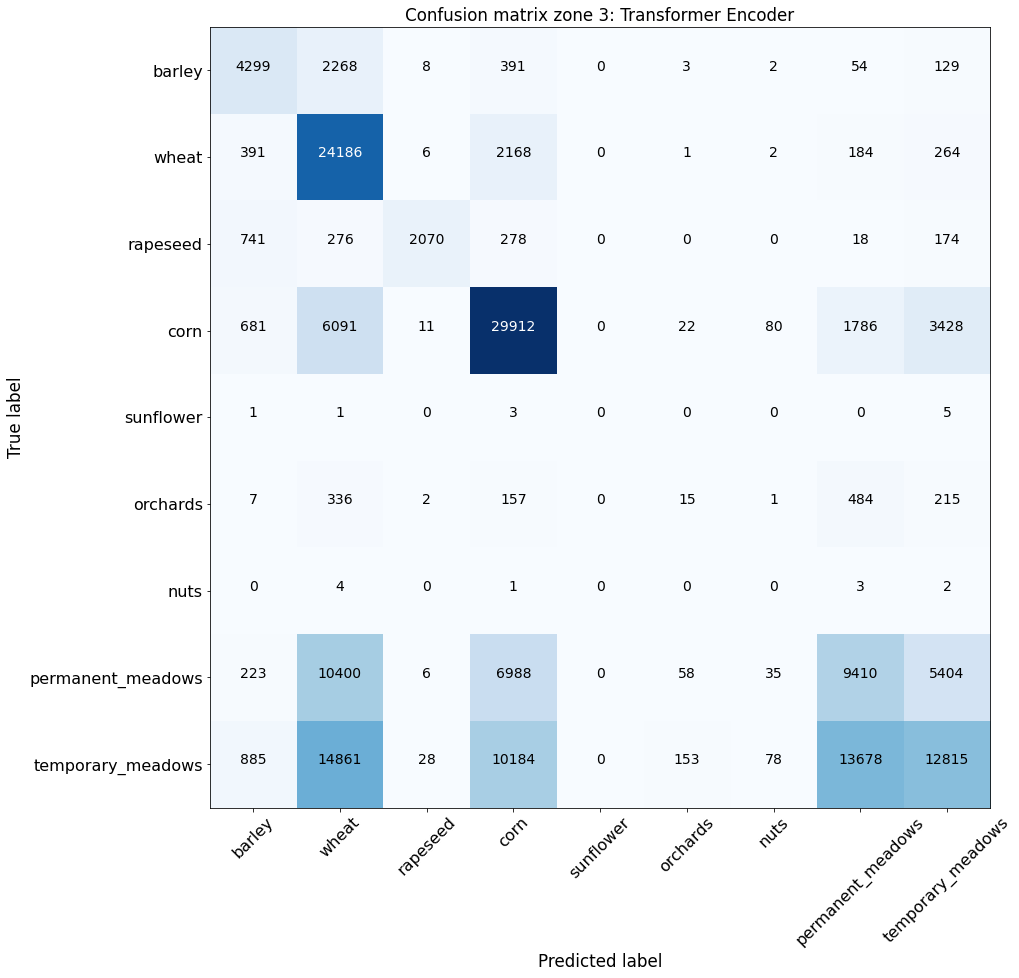

In [81]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
fig = plt.figure(figsize=(14,13.5))
plot_confusion_matrix(cm, label_names, title = 'Confusion matrix zone 3: Transformer Encoder')
fig.savefig('feature_visualization/Transformer2_confusion_matrix_zone3.png')

# test all zones

In [18]:
source_zones = 4
test_zones = 4
dataloaders = [(zone1dataloader,'zone1'), (zone2dataloader,'zone2'), (zone3dataloader,'zone3'), (zone4dataloader,'zone4')]

criterion = torch.nn.CrossEntropyLoss(reduction="mean")

for i in range(source_zones):
    
    traindataloader = dataloaders[i][0]
    train_zone = dataloaders[i][1]
    print('Source zone:', train_zone)
    
    for j in range(test_zones):
        #if j != i:
            # DEFINE MODE DIR AND NAME
            path = 'models/torch_transformer/vio_trasformer_train'+str(i+1)
            model_dir = Path(path)
            model.load_state_dict(torch.load(model_dir))

            # SET TARGET DATA
            testdataloader = dataloaders[j][0]
            test_zone = dataloaders[j][1]
            print('Target zone:', test_zone)

            test_loss, y_true, y_pred, *_ = test_epoch(model, criterion, testdataloader, device)

            scores = metrics(y_true.cpu(), y_pred.cpu())
            scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])
            
            test_loss = test_loss.cpu().detach().numpy()[0]
            print(scores)

Source zone: zone1
Target zone: zone1


test loss=0.30: 100%|██████████| 698/698 [00:20<00:00, 33.74it/s]


{'accuracy': 0.857701867526535, 'kappa': 0.81829669235882, 'f1_micro': 0.857701867526535, 'f1_macro': 0.8239656881880898, 'f1_weighted': 0.8558277428569058, 'recall_micro': 0.857701867526535, 'recall_macro': 0.7917590694528339, 'recall_weighted': 0.857701867526535, 'precision_micro': 0.857701867526535, 'precision_macro': 0.8927781394587984, 'precision_weighted': 0.8557952797791761}
Target zone: zone2


test loss=0.46: 100%|██████████| 550/550 [00:16<00:00, 32.75it/s]


{'accuracy': 0.7876646162151412, 'kappa': 0.7228622512858396, 'f1_micro': 0.7876646162151412, 'f1_macro': 0.567496705831137, 'f1_weighted': 0.7734341115876994, 'recall_micro': 0.7876646162151412, 'recall_macro': 0.5677169804905013, 'recall_weighted': 0.7876646162151412, 'precision_micro': 0.7876646162151412, 'precision_macro': 0.6376557937156316, 'precision_weighted': 0.8146551391818033}
Target zone: zone3


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
test loss=0.66: 100%|██████████| 650/650 [00:19<00:00, 33.47it/s]


{'accuracy': 0.7435969873833153, 'kappa': 0.6605735008612301, 'f1_micro': 0.7435969873833153, 'f1_macro': 0.5266342607954775, 'f1_weighted': 0.7300628222655894, 'recall_micro': 0.7435969873833153, 'recall_macro': 0.5199705426130464, 'recall_weighted': 0.7435969873833153, 'precision_micro': 0.7435969873833153, 'precision_macro': 0.5577377858834139, 'precision_weighted': 0.7391273349476076}
Target zone: zone4


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
test loss=0.37: 100%|██████████| 480/480 [00:14<00:00, 33.09it/s]


{'accuracy': 0.7941373015614304, 'kappa': 0.7293945611911615, 'f1_micro': 0.7941373015614304, 'f1_macro': 0.567496067748434, 'f1_weighted': 0.7863498107663256, 'recall_micro': 0.7941373015614304, 'recall_macro': 0.5633461424499615, 'recall_weighted': 0.7941373015614304, 'precision_micro': 0.7941373015614304, 'precision_macro': 0.597235558102056, 'precision_weighted': 0.7933392947129037}
Source zone: zone2
Target zone: zone1


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
test loss=0.82: 100%|██████████| 698/698 [00:21<00:00, 32.97it/s]


{'accuracy': 0.743254288145461, 'kappa': 0.6772857139632543, 'f1_micro': 0.743254288145461, 'f1_macro': 0.5308891425696358, 'f1_weighted': 0.7381018953972789, 'recall_micro': 0.743254288145461, 'recall_macro': 0.5342995146619862, 'recall_weighted': 0.743254288145461, 'precision_micro': 0.743254288145461, 'precision_macro': 0.5442810217925114, 'precision_weighted': 0.759074407361478}
Target zone: zone2


test loss=0.25: 100%|██████████| 550/550 [00:16<00:00, 32.98it/s]


{'accuracy': 0.8951357417851714, 'kappa': 0.8638435851877733, 'f1_micro': 0.8951357417851714, 'f1_macro': 0.9121515054171334, 'f1_weighted': 0.8951997967237293, 'recall_micro': 0.8951357417851714, 'recall_macro': 0.8996989041918854, 'recall_weighted': 0.8951357417851714, 'precision_micro': 0.8951357417851714, 'precision_macro': 0.9320525665803543, 'precision_weighted': 0.8958853285443849}
Target zone: zone3


test loss=2.79: 100%|██████████| 650/650 [00:19<00:00, 33.32it/s]


{'accuracy': 0.4966850397013831, 'kappa': 0.36421185294175507, 'f1_micro': 0.4966850397013831, 'f1_macro': 0.3592014257920573, 'f1_weighted': 0.4690219322019854, 'recall_micro': 0.4966850397013831, 'recall_macro': 0.3704056014182677, 'recall_weighted': 0.4966850397013831, 'precision_micro': 0.4966850397013831, 'precision_macro': 0.39944266137421036, 'precision_weighted': 0.5176944371369273}
Target zone: zone4


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
test loss=1.70: 100%|██████████| 480/480 [00:14<00:00, 32.85it/s]


{'accuracy': 0.600612836978844, 'kappa': 0.491230021857485, 'f1_micro': 0.600612836978844, 'f1_macro': 0.4395132388574796, 'f1_weighted': 0.5884121428834371, 'recall_micro': 0.600612836978844, 'recall_macro': 0.45026827353344, 'recall_weighted': 0.600612836978844, 'precision_micro': 0.600612836978844, 'precision_macro': 0.4484927598739643, 'precision_weighted': 0.6071928162493075}
Source zone: zone3
Target zone: zone1


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
test loss=0.53: 100%|██████████| 698/698 [00:21<00:00, 33.01it/s]


{'accuracy': 0.7767029423619508, 'kappa': 0.7122282410997121, 'f1_micro': 0.7767029423619508, 'f1_macro': 0.533930603143397, 'f1_weighted': 0.7570782028571965, 'recall_micro': 0.7767029423619508, 'recall_macro': 0.5364615047550437, 'recall_weighted': 0.7767029423619508, 'precision_micro': 0.7767029423619508, 'precision_macro': 0.5460523351953295, 'precision_weighted': 0.7624668694015427}
Target zone: zone2


test loss=0.99: 100%|██████████| 550/550 [00:16<00:00, 33.33it/s]


{'accuracy': 0.663813555710247, 'kappa': 0.5615283709107355, 'f1_micro': 0.663813555710247, 'f1_macro': 0.4594020626970946, 'f1_weighted': 0.5999556968996774, 'recall_micro': 0.663813555710247, 'recall_macro': 0.4829063208240741, 'recall_weighted': 0.663813555710247, 'precision_micro': 0.663813555710247, 'precision_macro': 0.500062511824488, 'precision_weighted': 0.6858940522144065}
Target zone: zone3


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
test loss=0.25: 100%|██████████| 650/650 [00:19<00:00, 32.88it/s]


{'accuracy': 0.8750353134936616, 'kappa': 0.8365231710699004, 'f1_micro': 0.8750353134936617, 'f1_macro': 0.9001174166361109, 'f1_weighted': 0.8725861776166306, 'recall_micro': 0.8750353134936616, 'recall_macro': 0.8780251780761846, 'recall_weighted': 0.8750353134936616, 'precision_micro': 0.8750353134936616, 'precision_macro': 0.9304974015316295, 'precision_weighted': 0.8735887392312681}
Target zone: zone4


test loss=0.43: 100%|██████████| 480/480 [00:14<00:00, 33.38it/s]


{'accuracy': 0.7347524203800894, 'kappa': 0.6503645017841302, 'f1_micro': 0.7347524203800895, 'f1_macro': 0.5073842779191451, 'f1_weighted': 0.709484488957553, 'recall_micro': 0.7347524203800894, 'recall_macro': 0.5184508999958501, 'recall_weighted': 0.7347524203800894, 'precision_micro': 0.7347524203800894, 'precision_macro': 0.5178146024633418, 'precision_weighted': 0.7252250882788938}
Source zone: zone4
Target zone: zone1


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
test loss=0.53: 100%|██████████| 698/698 [00:21<00:00, 32.38it/s]


{'accuracy': 0.7926631286667563, 'kappa': 0.7354245300110773, 'f1_micro': 0.7926631286667563, 'f1_macro': 0.5551444573429539, 'f1_weighted': 0.7915901831468507, 'recall_micro': 0.7926631286667563, 'recall_macro': 0.5525998918072293, 'recall_weighted': 0.7926631286667563, 'precision_micro': 0.7926631286667563, 'precision_macro': 0.5618510371854306, 'precision_weighted': 0.7908919660009366}
Target zone: zone2


test loss=0.64: 100%|██████████| 550/550 [00:16<00:00, 33.90it/s]


{'accuracy': 0.760004830162947, 'kappa': 0.687023483288691, 'f1_micro': 0.760004830162947, 'f1_macro': 0.5443445538484364, 'f1_weighted': 0.7558720310676547, 'recall_micro': 0.760004830162947, 'recall_macro': 0.5418678801480387, 'recall_weighted': 0.760004830162947, 'precision_micro': 0.760004830162947, 'precision_macro': 0.5563378556264309, 'precision_weighted': 0.7668226934270372}
Target zone: zone3


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
test loss=1.01: 100%|██████████| 650/650 [00:18<00:00, 34.46it/s]


{'accuracy': 0.7111025624072081, 'kappa': 0.6229515759814717, 'f1_micro': 0.7111025624072081, 'f1_macro': 0.49612447248808755, 'f1_weighted': 0.7074735612995647, 'recall_micro': 0.7111025624072081, 'recall_macro': 0.5024288309243885, 'recall_weighted': 0.7111025624072081, 'precision_micro': 0.7111025624072081, 'precision_macro': 0.5019733081556221, 'precision_weighted': 0.7102529246209196}
Target zone: zone4


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
test loss=0.12: 100%|██████████| 480/480 [00:14<00:00, 32.63it/s]


{'accuracy': 0.8870081820256218, 'kappa': 0.8526612169748766, 'f1_micro': 0.8870081820256218, 'f1_macro': 0.9021097173170131, 'f1_weighted': 0.8861056787649692, 'recall_micro': 0.8870081820256218, 'recall_macro': 0.8824961594613668, 'recall_weighted': 0.8870081820256218, 'precision_micro': 0.8870081820256218, 'precision_macro': 0.9325903322252275, 'precision_weighted': 0.8864571181962133}
